In [214]:
import torch
import torchaudio

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [160]:
def convert_to_wav(path: str, target_sr: int = 16000, mono: bool = True) -> str:
    """
    m4a/mp3 등 어떤 포맷이 와도 ffmpeg로 16kHz/mono WAV로 변환.
    반환: 변환된 임시 WAV 경로
    """
    tmp_wav = tempfile.NamedTemporaryFile(suffix=".wav", delete=False).name
    cmd = ["ffmpeg", "-y", "-i", path]
    if target_sr: cmd += ["-ar", str(target_sr)]
    if mono: cmd += ["-ac", "1"]
    cmd += [tmp_wav]
    # ffmpeg 출력 숨김
    subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return tmp_wav

def load_audio_any(path: str, target_sr: int = 16000):
    """
    어떤 입력이 와도 convert_to_wav로 16kHz/mono WAV로 바꾼 다음 torchaudio.load.
    반환: (waveform[Torch: [1, T]], sample_rate, wav_path)
    """
    wav_path = convert_to_wav(path, target_sr=target_sr, mono=True)
    waveform, sr = torchaudio.load(wav_path)  # [channels=1, time]
    return waveform, sr, wav_path

In [161]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = "./source.mp3"  


In [162]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [163]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [164]:
IPython.display.Audio(SPEECH_FILE)

In [165]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [166]:
labels = bundle.get_labels()
target_sr = bundle.sample_rate  # 16000

In [167]:
import tempfile, subprocess
import IPython.display as ipd 

# 1) 로드 (항상 16kHz mono WAV로 변환 뒤 로드됨)
waveform, sample_rate, tmp_wav = load_audio_any(SPEECH_FILE, target_sr=target_sr)

# 2) (선택) 재생
display(ipd.Audio(tmp_wav))

# 3) 디바이스로 이동
waveform = waveform.to(device)

In [168]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

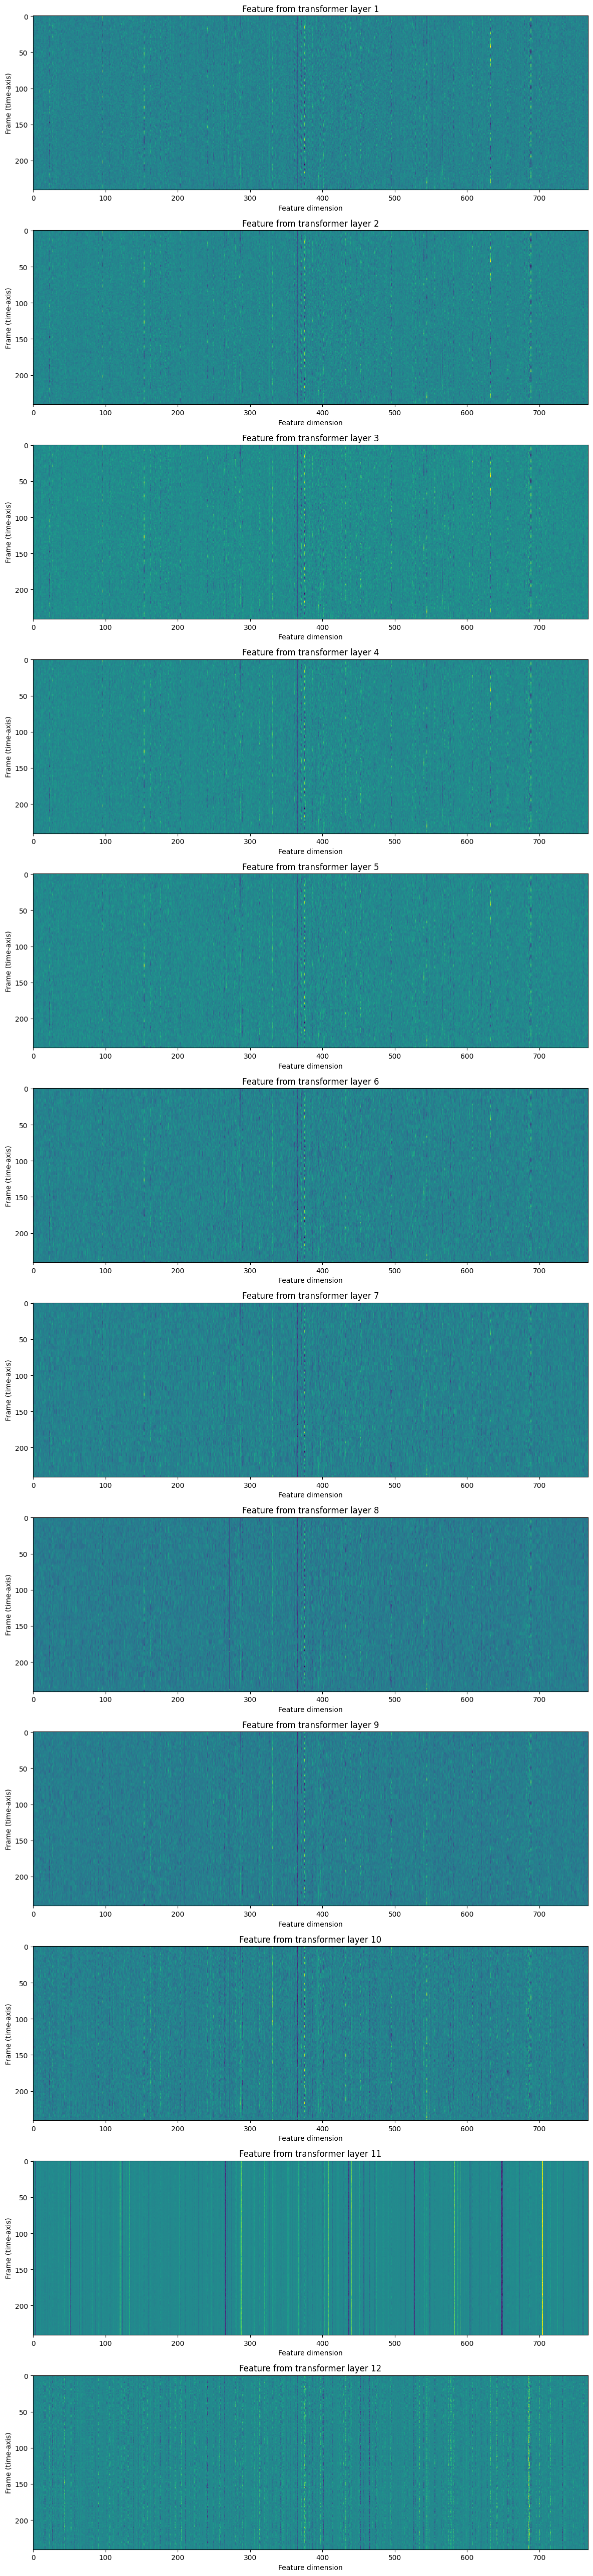

In [169]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [170]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


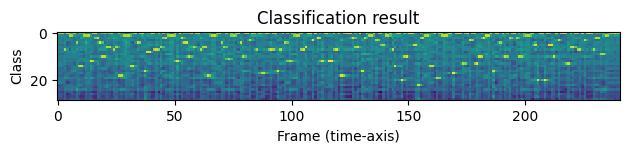

In [171]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [172]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [173]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [174]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|AM|LEARNING|MACHINE|LEARNING|AND|ARTIFICIAL|INTELLIGENCE|TO|IMPROVE|MY|FUTURE|CAREER|OPPORTUNITIES|


In [175]:
!pip install jiwer librosa soxr